In [1]:
# 5. Написать программу, позволяющую проверять для текста выполнение закона Ципфа-Мальдеброта. Программа должна:

#     1. осуществлять морфологический анализ словоформ текста;
#     2. подсчитывать частоты и ранги различных словоформ и лемм;
#     3. выводить списки самых частотных словоформ и лемм;
#     4. строить графики (реальный и ожидаемый) зависимости относительной частоты от ранга словоформы и леммы.

# Отчет: программа с комментариями, подсчитанная статистика, комментарии к способу ее подсчета, описание проведенных тестов, выводы.

# Прикладные задачи: оценка естественности текста, определение стиля/жанра текста.

In [2]:
#importing modules
import nltk
from nltk.tokenize import word_tokenize 
from nltk.tokenize.punkt import PunktSentenceTokenizer

import pymorphy2
import string
from collections import Counter
import operator
import matplotlib.pyplot as plt

In [3]:
#method tokenizers

def Sent_tokenizing(Text):
    #tokenize by sentences
    Text_sent_tokenized=[]
    tokenizer = PunktSentenceTokenizer()
    paragraphs = [p for p in Text.split('\n') if p] #spliting by \n
    for paragraph in paragraphs:
        Text_sent_tokenized += tokenizer.tokenize(paragraph,'russian')
    return Text_sent_tokenized

def Word_tokenizing(Text):
    #tokenize by words
    special_words=string.punctuation
    special_words+='»'+'«'+'–'+'”'+'“'+'—' #add punctuations, that doesnt excist in module
    Text_tokens=nltk.word_tokenize(Text)
    t_tokenized=[]
    
    #delete puntuations
    for word in Text_tokens:
        if word not in special_words:
            t_tokenized.append(word)
    return t_tokenized

In [4]:
#text preset method
#returns 
#1.dictionary sorted bey absolute frequency
#2.dictionary with positions
#3.MorphAnalyzer in pymorphy2

def text_preset(Text):
    #additional methods
    def morphy(word,morph):
        #retuns normal form and posintion of word
        #it mistakes when word has multiple meaning
        parse= morph.parse(word)[0]
        return parse.normal_form,parse.tag.POS
    def import_stop_words():
        #stop words including
        #words from module were not enough
        stop_words_file=open("stop_words.txt",'r',encoding="utf-8")
        stop_words_list=stop_words_file.read()
        stop_words_file.close()
        stop_words=stop_words_list.split('\n')

        return stop_words

    #make list to analize morphic structure
    #make dictionary to analyze style of text
    Text_tokenized=Word_tokenizing(Text)
    Text_morphy=[]
    Text_dict={}

    morph = pymorphy2.MorphAnalyzer()
    for word_ in Text_tokenized:
        word , pos=morphy(word_,morph)
        Text_morphy.append(word)
        Text_dict[word]=pos

    #clear digits and stop words
    Text_cleared=[]
    stop_words=import_stop_words()
    for word in Text_morphy:
        if not word.isdigit() and word not in stop_words:
            Text_cleared.append(word)
    
    Text_counted=dict(Counter(Text_cleared))
    Text_sorted=dict(sorted(Text_counted.items(),key=operator.itemgetter(1), reverse=True)) #sort by absolute frequency
    
    return Text_sorted,Text_dict,morph

In [5]:
def frequency_clac(Text_sorted):
    def get_wordform_len(word,morph):
        #return length of word form in 'word'
        parse=morph.parse(word)
        return len(parse)
    
    #make Rank of each words by absolute frequency
    j=1
    rank={}#rank of each words
    for word in Text_sorted.keys():
        rank[word]=j
        j+=1

    #calculate frequency for each words that inversely proportional of rank
    #law of Zipf
    frequency_ideal={}
    for word in rank.keys():
        frequency_ideal[word]=0.08/rank[word]#В НКРЯ 0.08

    frequency_practical={}
    for word in rank.keys():
        C=0.08*Text_sorted[word]/get_wordform_len(word,morph)
        frequency_practical[word]=C/rank[word]
        
    return frequency_ideal,frequency_practical

In [6]:
def Draw_frequencies(ideal,practical):
    #Draw graph of frequency/rank
    plt.title(f'распределение для {len(Text_sorted)} слов')
    plt.plot(ideal.values(),label='теорет. распр.') #y-gives frequency
    plt.plot(practical.values(),label='прак. распр.')
    plt.xlabel('ранг слова')
    plt.ylabel('относительная частота')
    plt.legend()
    plt.show()

    #print the highest 10 practical frequenty
    key=list(practical.keys())
    value=list(practical.values())

    if len(key)<10:
        p_max=len(key)
    else:
        p_max=10

    print(f'The highest {p_max} ranks and practical frequencies')
    for i in range(p_max): 
        print(key[i],':',value[i])

In [7]:
def Beta_count(Text_dict):
    #параметр β, отражающий соотношение динамичности и статичности текстов коллекции
    # #(гл+сущ) + #(гл+нар) + #(деепр+сущ) + #(деепр+нар) )/(#(сущ+сущ) + #(прил+сущ)), 
    #где # – количество конструкций определённого типа
    Dict_for_beta={'VERB+NOUN':0,'VERB+ADVB':0,'GRND+NOUN':0,'GRND+ADVB':0,'NOUN+NOUN':0,'ADJF+NOUN':0}
    prev=''
    #count parameters required by formular
    for word in Text_dict.keys():
        if prev=='':
            prev=word
            continue
        if Text_dict[prev]=='VERB':
            if Text_dict[word]=='NOUN':
                Dict_for_beta['VERB+NOUN']+=1
            elif Text_dict[word]=='ADVB':
                Dict_for_beta['VERB+ADVB']+=1
        elif Text_dict[prev]=='GRND':
            if Text_dict[word]=='NOUN':
                Dict_for_beta['GRND+NOUN']+=1
            elif Text_dict[word]=='ADVB':
                Dict_for_beta['GRND+ADVB']+=1
        elif Text_dict[prev]=='NOUN':
            if Text_dict[word]=='NOUN':
                Dict_for_beta['NOUN+NOUN']+=1
        elif Text_dict[prev]=='ADJF':
            if Text_dict[word]=='NOUN':
                Dict_for_beta['ADJF+NOUN']+=1
        prev=word

    Beta_up=(Dict_for_beta['VERB+NOUN']+Dict_for_beta['VERB+ADVB']+Dict_for_beta['GRND+NOUN']+Dict_for_beta['GRND+ADVB'])
    Beta_down=Dict_for_beta['NOUN+NOUN']+Dict_for_beta['ADJF+NOUN']
    if Beta_down==0:
        Beta='Unknown'
    else:
        Beta=Beta_up/Beta_down
    
    return Beta

In [8]:
def Style_recognize(Text_dict,Text):
    #определение стиля/жанра текста.
    Beta=Beta_count(Text_dict)

    #counting midium длины предложения
    #midium length=length of each sentece / length of all sentences divided by sentence
    Sent_tokens=Sent_tokenizing(Text)
    Sent_tokenized=[]
    for sent in Sent_tokens:
        Sent_tokenized.append(Word_tokenizing(sent))

    mid_len_sent=0
    for sent in Sent_tokenized:
        mid_len_sent+=len(sent)
    mid_len_sent/=len(Sent_tokens)

    #calculating other parameter
    Dict_count=dict(Counter(Text_dict.values()))
    
    #check if needed parameter is not in dictionary
    ex=Dict_count.keys()
    if 'NPRO' not in ex:
        Dict_count['NPRO']=0
    if 'PRCL' not in ex:
        Dict_count['PRCL']=0
    if 'ADJF' not in ex:
        Dict_count['ADJF']=0

    NPRO=Dict_count['NPRO']/len(Text_sorted) #доля частиц
    PRCL=Dict_count['PRCL']/len(Text_sorted) #доля местоимений
    ADJF=Dict_count['ADJF']/len(Text_sorted) #доля прилагательных
    
    #print parameters
    print('\nParameters of Style recognizing')
    print('Beta=',Beta)
    print(f"midium length of sentences= {mid_len_sent}")
    print(f"доля частиц= {NPRO}\nдоля местоимений= {PRCL}\nдоля прилагательных= {ADJF}")

    #return
    if Beta=='Unknown':
        return 'Unknown style'
    else:
        if mid_len_sent>=18 and Beta<=0.1:
            return 'Деловой стиль'
        elif NPRO>=0.02 and PRCL>=0.03:
            return 'Художественный стиль'
        elif 0.1<=ADJF<=0.2 and NPRO<=0.025 and Beta<=0.32:
            return 'Научный стиль'
        else:
            return 'Публицистический стиль'

In [9]:
#make text object from file
file_name=input("Please input the file name:")
file=open(file_name,'r',encoding='UTF-8')
Text=file.read()
file.close()

Text_sorted,Text_dict,morph=text_preset(Text)
ideal,practical=frequency_clac(Text_sorted)
style=Style_recognize(Text_dict,Text)

Please input the file name: text.txt



Parameters of Style recognizing
Beta= 0.0
midium length of sentences= 22.0
доля частиц= 0.041666666666666664
доля местоимений= 0.041666666666666664
доля прилагательных= 0.3333333333333333


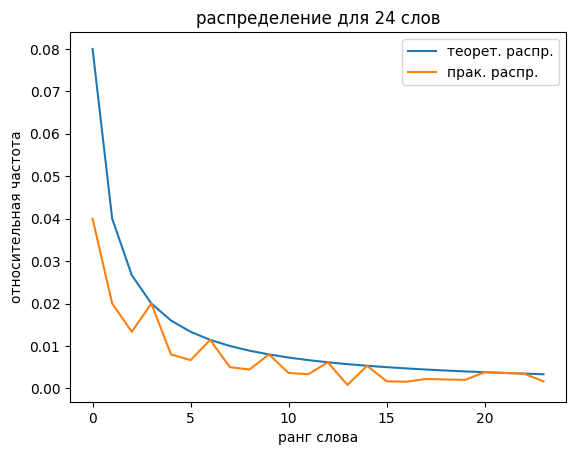

The highest 10 ranks and practical frequencies
дождь : 0.04
крупный : 0.02
дробь : 0.013333333333333334
барабанить : 0.02
капюшон : 0.008
плащ : 0.006666666666666667
наполнять : 0.011428571428571429
осенний : 0.005
мокрый : 0.0044444444444444444
прохлада : 0.008

Деловой стиль


In [10]:
Draw_frequencies(ideal,practical)
print()
print(style)